In [1]:
import pandas as pd
import numpy as np
import json

import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
from log_parser import process_file


### parameters

In [3]:
_fname = "../replays/log5.log"
_time_step = 100
_symbols = ["PEARLS", "BANANAS"]
_products = ["PEARLS", "BANANAS"]


### pre processing

In [4]:
# load data from file

obj = process_file(_fname)
df = pd.DataFrame(obj)

listings = pd.DataFrame(df["listings"][0])
products = set(listings.T["product"])
df = df.drop("listings", axis=1)
df = df.rename({
    "timestamp": "time",
    "order_depths": "book",
}, axis=1)

Reading from input file ../replays/log5.log


In [5]:
# add turns (vs time)

all_times = df["time"]
turn2time_map = all_times.to_dict()
time2turn_map = {v: k for k, v in turn2time_map.items()}
df["turn"] = df["time"].map(time2turn_map)

df.index = df["turn"]

In [6]:
def process_book(book):
    best_buy = {}
    best_sell = {}
    ret = {}
    cols = ["price", "quantity"]
    for sym in _symbols:
        orders = {
            "buy": pd.DataFrame(columns=cols),
            "sell": pd.DataFrame(columns=cols),
        }
        
        if sym in book:
            if "buy_orders" in book[sym]:
                orders["buy"] = pd.DataFrame(book[sym]["buy_orders"].items(), columns=cols).sort_values(by="price", ascending=False)
            if "sell_orders" in book[sym]:
                orders["sell"] = pd.DataFrame(book[sym]["sell_orders"].items(), columns=cols).sort_values(by="price", ascending=True)
        
        ret[sym] = orders
        
        if len(orders["buy"]) > 0:
            best_buy[sym] = orders["buy"]["price"][0]
        else:
            best_buy[sym] = np.nan
            
        if len(orders["sell"]) > 0:
            best_sell[sym] = orders["sell"]["price"][0]
        else:
            best_sell[sym] = np.nan
            
        
    return ret, best_buy, best_sell


books = pd.DataFrame(df["book"].apply(process_book).to_list(), columns=["book", "best_buy", "best_sell"])
book_tops = books.drop("book", axis=1)

# all book tops
book_tops = pd.concat([book_tops[c].apply(pd.Series).add_suffix(f"_{c}") for c in book_tops.columns], axis=1).astype(int)

for sym in _symbols:
    book_tops[f"{sym}_mid"] = (book_tops[f"{sym}_best_buy"] + book_tops[f"{sym}_best_sell"]) / 2
    book_tops[f"{sym}_spread"] = book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"]
    assert book_tops[f"{sym}_spread"].all() > 0

# sort columns
book_tops = book_tops.reindex(sorted(book_tops.columns), axis=1)
book_tops["time"] = df["time"]

# all books
books = books["book"]

In [7]:
num_data = len(book_tops.dropna())
num_data_dropna = len(book_tops)

print(f"Orig count: {num_data}")
print(f"dropna count: {num_data_dropna}")
print(f"nan count: {num_data - num_data_dropna}")

Orig count: 1999
dropna count: 1999
nan count: 0


In [8]:
def flatten_trades(df, col, is_me):
    # get market trades

    data = []
    for index, row  in df.iterrows():
        all_trades = list(row[col].values())
        for sym_trades in all_trades:
            for trade in sym_trades:
                trade["time"] = row["time"] # fill time
                trade["turn"] = row["turn"] # fill time
            data += sym_trades

    df = pd.DataFrame(data)
    df = df.rename({"timestamp": "order_time"}, axis=1)
    
    # calculate info about my trades
    df["is_me"] = is_me
    df["my_action"] = None
    df["my_action"] = np.where(df["buyer"] == "SUBMISSION", "buy", df["my_action"])
    df["my_action"] = np.where(df["seller"] == "SUBMISSION", "sell", df["my_action"])
    df["my_quantity"] = df["quantity"] * df["is_me"].astype(int) * (2 * (df["my_action"] == "buy").astype(int) - 1)
    
    return df

In [9]:
# get my_trades, market_trades, and trade_df (all_trades)

market_trades = flatten_trades(
    df, 
    "market_trades", 
    is_me=False
).sort_values(by="time")

my_trades = flatten_trades(
    df, 
    "own_trades", 
    is_me=True
).sort_values(by="time")


# filter market trades (only keep those where order_time = fill_time)
market_trades = market_trades[market_trades["time"] == market_trades["order_time"]]

# filter my_trades (only keep those where fill_time = order_time + 100)
my_trades = my_trades[my_trades["time"] == my_trades["order_time"] + _time_step]


trade_df = pd.concat([market_trades, my_trades])
trade_df = trade_df.sort_values(by="time").reset_index(drop=True)
# trade_df = trade_df.drop(["order_time", "buyer", "seller"], axis=1)

my_trades = trade_df[trade_df["is_me"]]
market_trades = trade_df[~trade_df["is_me"]]

print("my_trades count", len(my_trades))
print("market_trades count", len(market_trades))


my_trades count 113
market_trades count 294


In [11]:
# get my_positions
my_positions = pd.DataFrame(list(df["position"])).fillna(0)

# add any products of zero quantity
for prod in _products:
    if prod not in my_positions:
        my_positions[prod] = 0
        
my_positions[["time", "turn"]] = df[["time", "turn"]]
my_positions = my_positions.sort_values(by="time")

# add cash to my_positions
cash_data = []
cur_cash = 0
cur_time = turn2time_map[0]
for index, row in my_trades.iterrows():
    row_time = row["time"]
    while cur_time < row["time"]:
        cash_data += [cur_cash]
        cur_time = turn2time_map[len(cash_data)]
        
    cur_cash += -1 * row["price"] * row["my_quantity"]

# add for remaining turns
while cur_time < max(turn2time_map.values()):
    cash_data += [cur_cash]
    cur_time = turn2time_map[len(cash_data)]
cash_data += [cur_cash]

# add to my_positions
my_positions["cash"] = cash_data






### Data analysis/vis
- for info about trades:
    - `trade_df` (all trades)
    - `my_trades` (our trades only)
    - `market_trades` (other people's trades only, not our trades)
- for info about our positions
    - `my_positions`

### todo:
- my_positions
    - calculate approx product price per turn
    - calculate total inventory value + total net worth (aka pnl)
- visualize book

In [12]:
book_tops

,BANANAS_best_buy,BANANAS_best_sell,BANANAS_mid,BANANAS_spread,PEARLS_best_buy,PEARLS_best_sell,PEARLS_mid,PEARLS_spread,time
0,4892,4899,4895.5,7,9995,10005,10000.0,10,0
1,4892,4896,4894.0,4,9995,10002,9998.5,7,100
2,4892,4899,4895.5,7,9995,10004,9999.5,9,200
3,4893,4899,4896.0,6,9995,9998,9996.5,3,300
4,4893,4899,4896.0,6,9995,10004,9999.5,9,400
...,...,...,...,...,...,...,...,...,...
1994,4905,4912,4908.5,7,9995,9998,9996.5,3,199500
1995,4905,4912,4908.5,7,9995,10005,10000.0,10,199600
1996,4904,4911,4907.5,7,9995,10004,9999.5,9,199700
1997,4905,4911,4908.0,6,9995,10004,9999.5,9,199800


In [13]:
# estimate fairs
mid_cols = [col for col in book_tops.columns if "_mid" in col]
fairs = book_tops[["time", *mid_cols]]
fairs.columns = fairs.columns.str.strip('_mid')
fairs

,time,BANANAS,PEARLS
0,0,4895.5,10000.0
1,100,4894.0,9998.5
2,200,4895.5,9999.5
3,300,4896.0,9996.5
4,400,4896.0,9999.5
...,...,...,...
1994,199500,4908.5,9996.5
1995,199600,4908.5,10000.0
1996,199700,4907.5,9999.5
1997,199800,4908.0,9999.5


In [14]:
# estimate pnl
pnls = my_positions["cash"]

for prod in products:
    pnls += my_positions[prod] * fairs[prod]
    
my_positions["pnl"] = pnls

In [15]:
my_positions

,BANANAS,PEARLS,time,turn,cash,pnl
0,0.0,0.0,0,0,0.0,0.0
1,0.0,0.0,100,1,0.0,0.0
2,0.0,0.0,200,2,0.0,0.0
3,0.0,0.0,300,3,0.0,0.0
4,0.0,0.0,400,4,0.0,0.0
...,...,...,...,...,...,...
1994,0.0,0.0,199500,1994,226.0,226.0
1995,0.0,0.0,199600,1995,226.0,226.0
1996,0.0,0.0,199700,1996,226.0,226.0
1997,0.0,0.0,199800,1997,226.0,226.0


In [16]:
book_tops

,BANANAS_best_buy,BANANAS_best_sell,BANANAS_mid,BANANAS_spread,PEARLS_best_buy,PEARLS_best_sell,PEARLS_mid,PEARLS_spread,time
0,4892,4899,4895.5,7,9995,10005,10000.0,10,0
1,4892,4896,4894.0,4,9995,10002,9998.5,7,100
2,4892,4899,4895.5,7,9995,10004,9999.5,9,200
3,4893,4899,4896.0,6,9995,9998,9996.5,3,300
4,4893,4899,4896.0,6,9995,10004,9999.5,9,400
...,...,...,...,...,...,...,...,...,...
1994,4905,4912,4908.5,7,9995,9998,9996.5,3,199500
1995,4905,4912,4908.5,7,9995,10005,10000.0,10,199600
1996,4904,4911,4907.5,7,9995,10004,9999.5,9,199700
1997,4905,4911,4908.0,6,9995,10004,9999.5,9,199800


In [50]:
smoothed

0       4895.500000
1       4894.710526
2       4895.001845
3       4895.292091
4       4895.464958
           ...     
1994    4906.599839
1995    4906.789855
1996    4906.860870
1997    4906.974783
1998    4907.127304
Name: BANANAS_mid, Length: 1999, dtype: float64

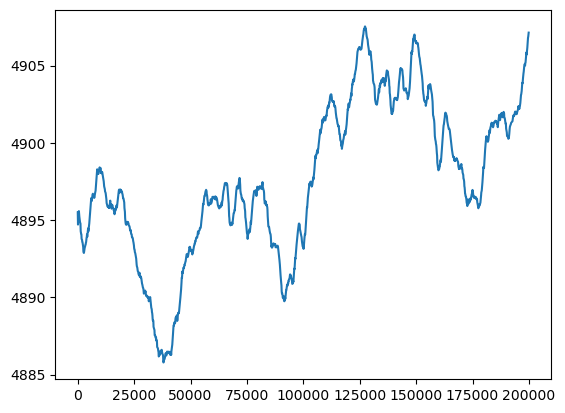

In [51]:
plt.plot(book_tops["time"], smoothed)

In [63]:
# plot trades
def plot_trades_and_book(sym, smooth_alpha=0.1):
    
    plt_df = trade_df[trade_df["symbol"] == sym]

    my_buys = plt_df[plt_df["my_quantity"] > 0]
    my_sells = plt_df[plt_df["my_quantity"] < 0]
    their_trades = plt_df[plt_df["my_quantity"] == 0]

    plt.scatter(my_buys["time"], my_buys["price"], c="green", s=25)
    plt.scatter(my_sells["time"], my_sells["price"], c="red", s=25)
    plt.scatter(their_trades["time"], their_trades["price"], c="gray", s=10)

    bids = book_tops[f"{sym}_best_buy"]
    asks = book_tops[f"{sym}_best_sell"]
    smooth_bids = bids.ewm(alpha=smooth_alpha).mean()
    smooth_asks = asks.ewm(alpha=smooth_alpha).mean()
    
    # plot book
    plt.plot(df["time"], bids, c="green", alpha=0.5, linewidth=0.5)
    plt.plot(df["time"], asks, c="red", alpha=0.5, linewidth=0.5)
    plt.title(f"Trades and book: {sym}")
    plt.show()
    
    plt.plot(df["time"], smooth_bids, c="green", alpha=0.75, linewidth=0.5)
    plt.plot(df["time"], smooth_asks, c="red", alpha=0.75, linewidth=0.5)
    plt.title(f"(smooth) Trades and book: {sym}")
    plt.show()
    

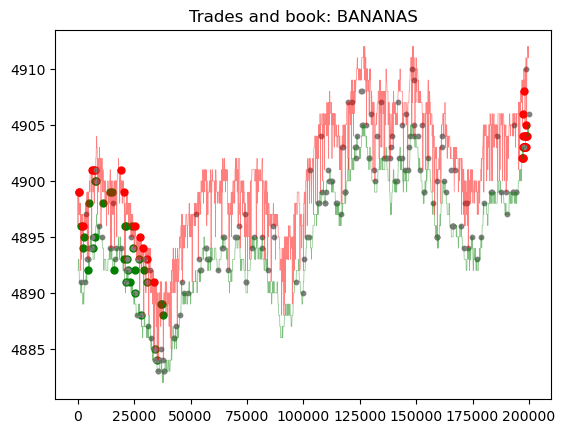

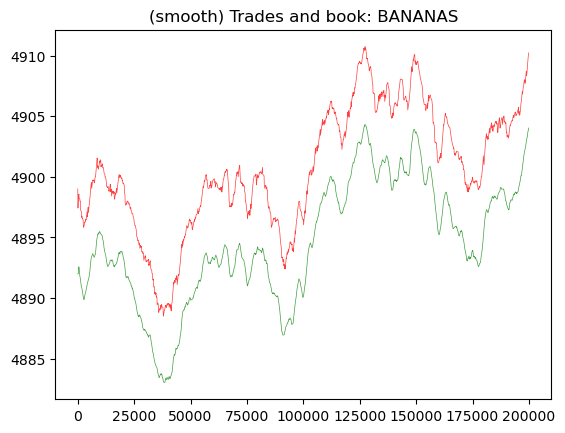

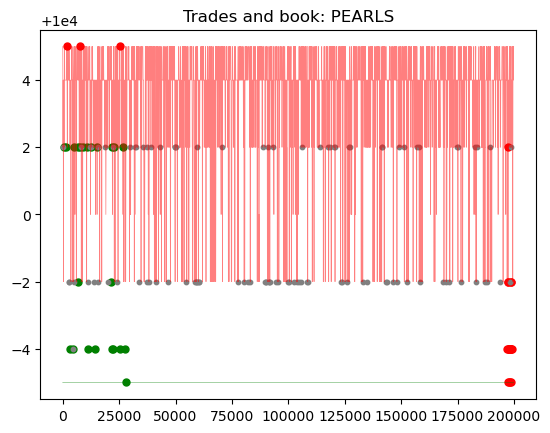

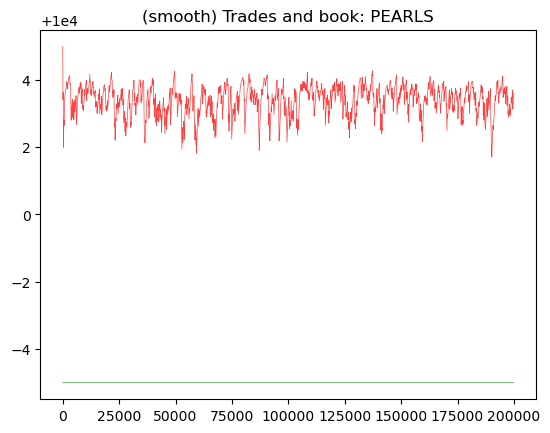

In [68]:
plot_trades_and_book(sym="BANANAS", smooth_alpha=0.1)
plot_trades_and_book(sym="PEARLS")

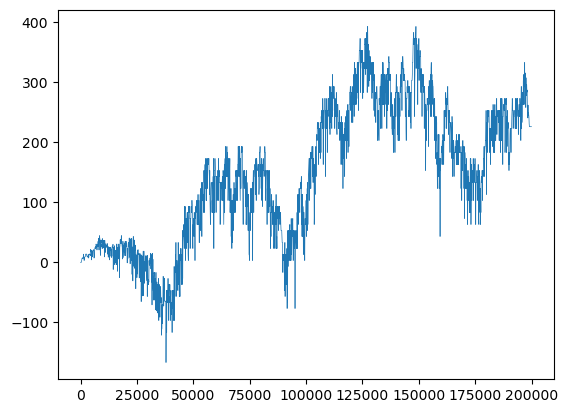

In [69]:
plt.plot(my_positions["time"], my_positions["pnl"], linewidth=0.5)

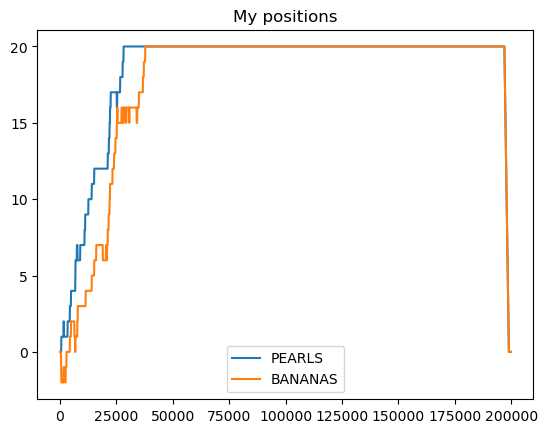

In [20]:
# plot my positions in each product

plt.plot(my_positions["time"], my_positions["PEARLS"], label="PEARLS")
plt.plot(my_positions["time"], my_positions["BANANAS"], label="BANANAS")
plt.title("My positions")
plt.legend()
plt.show()

In [21]:
col = book_tops["BANANAS_mid"]
diffs = (col.shift(-1) / col).dropna()
diffs.describe()

count    1998.000000
mean        1.000001
std         0.000233
min         0.999182
25%         0.999898
50%         1.000000
75%         1.000102
max         1.000819
Name: BANANAS_mid, dtype: float64

In [22]:
col = book_tops["PEARLS_mid"]
diffs = (col.shift(-1) / col).dropna()
diffs.describe()

count    1998.000000
mean        1.000000
std         0.000137
min         0.999650
25%         0.999950
50%         1.000000
75%         1.000050
max         1.000350
Name: PEARLS_mid, dtype: float64